# **R-NET Model Implementation**

In this notebook, we will walk through the implementation of an R-NET model as introduced in the paper [R-NET: Machine Reading Comprehension with Self-Matching Networks](https://www.microsoft.com/en-us/research/wp-content/uploads/2017/05/r-net.pdf). R-NET is an **end-to-end neural networks model** for r**eading comprehension style question answering**. The goal of R-NET is to answer questions from a given passage. 

An R-NET model consists of **four parts**: 

1. A recurrent network **encoder** that builds representation for questions and passages separately. 
2. A **gated attention-based layer** that matches the question and passage. 
3. A **self-matching attention layer** to aggregate information from the whole passage by matching the passage against itself. 
4. A **pointer network layer** that locates the positions of answers from the passages. 

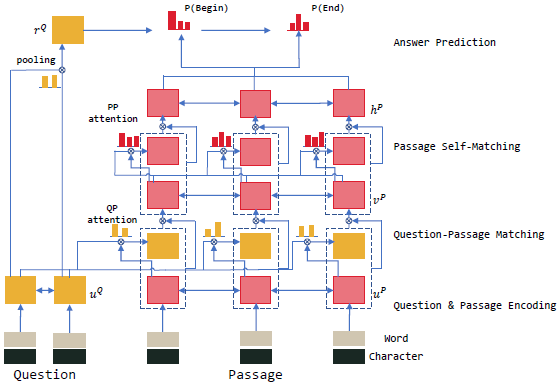

Our notebook will construct an R-NET model by defining four separate classes corresponding to four layers and later combining them together in an R-NET class. But first, we will define a layer that build the character-level representation for a word. Our implementation is as follows:

## **Set Up**

In [ ]:
# Import libraries
import os
import pickle
import ujson
from spacy.lang.en import English
tokenizer = English().tokenizer

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import traceback

from config import base_config
use_gpu = base_config.get("use_gpu",False)
device = torch.device("cuda" if torch.cuda.is_available() and use_gpu == True else "cpu")        

## **Embedding layer**
The first layer will perform the character embedding of each word. The motivation for such embedding is that character-level embeddings have been show to deal with out-of-vocab token (OOV). Together, both the character-level embedding and word-level embedding will be fed into the gated attention-based layer.

In [ ]:
class Encoder(nn.Module):
    def __init__(self,input_size=300, hidden_size=75, num_layers=3, bidirectional=True,dropout=0.2):
        super(Encoder, self).__init__()

        # Define a bidirectional RNN to encode the input matrix
        self.gru = nn.GRU(input_size=input_size,hidden_size=hidden_size, num_layers=num_layers, bidirectional=bidirectional)

        # Define a dropout layer
        if dropout is None:
            self.dropout = None
        else:
            self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, input):

        # Feed the input into the RNN model
        o, _ = self.gru(input) 
        
        # the shape of the output is (seq_len, batch, num_directions * hidden_size)
        # Then apply the dropout layer to the output
        o = self.dropout(o)
        return o

## **Gated Attention Layer**

The motivation for this layer is that based on the question, there must be some parts in the passage that is extremely important. Thus, this layer tries to match the similarity between the passage and the question by determining the importance of passage parts and attend to ones relevant to the question.

The model does this by calculating the score between each token in the question and the passage to determine which parts are important between them (similar to the attention mechanism). Then, the model uses the **match-LSTM** to update the representation of each token in the passage to determine their relationship with the question.

In [ ]:
class QuestionPassageCoAttention(nn.Module):
    # Initiate the layer 
    def __init__(self, hidden_size=75, batch_size=32):  
        super(QuestionPassageCoAttention, self).__init__()

        # Define the batch size and hidden embedding size
        self.batch_size = batch_size
        self.hidden_size = hidden_size

        # Define the matrix correspond to the embedding of a token of the question
        self.WQ_sub_u = torch.nn.Linear(2 * hidden_size, hidden_size)

        # Define the matrix correspond to the embedding of a token of the passage
        self.WP_sub_u = torch.nn.Linear(2 * hidden_size, hidden_size)

        # Define the matrix correspond to the previous sentence-pair representation
        self.WP_sub_v = torch.nn.Linear(hidden_size, hidden_size)

        # Define the matrix deals with matching the important parts of passage to the question
        self.Wg = torch.nn.Linear(4 * hidden_size, 4* hidden_size)

        # Initiate the passage representation which incorporates aggregated matching information from the question.
        self.Vt = torch.randn((self.batch_size, hidden_size, 1)).to(device)

        # Define two RNN layer, one is forward, one is backward
        self.gatedRNN_fwd = nn.GRUCell(input_size= 4*hidden_size, hidden_size=hidden_size)
        self.gatedRNN_rev = nn.GRUCell(input_size= 4*hidden_size, hidden_size=hidden_size)
        self.dropout = nn.Dropout(p=0.2)
        
    
    def forward(self, quesEnc, passEnc):

        # Collect the size of the sequence of passage encoding and question encoding
        """
        lQ: length of question
        lP: length of question
        hiddenP: hidden size (output features size or size of last dim) of passage encoding (available here as passEnc) from the 'Encoding' Layer
        hiddenQ: hidden size (output features size or size of last dim) of question encoding (available here as quesEnc) from the 'Encoding' Layer i.e.
        bP: batch size received for the passEnc
        bQ: batch size received for the quesEnc 
        """
        lP, bP, hiddenP = passEnc.shape
        lQ, bQ, hiddenQ = quesEnc.shape
        
        # Initiate the sentence-pair representation
        prev_vP_fwd = torch.randn((bP, self.hidden_size)).to(device) # (b,h)
        prev_vP_rev = torch.randn((bP, self.hidden_size)).to(device) # (b,h)

        # Initiate a matrix to store all there representation
        vP_all_timesteps = torch.zeros(lP, bP, 2*self.hidden_size).to(device) # (lP,b,2h)
        
        
        # save quesEnc as shape with batch first i.e. (lQ, b, 2h) -> (b, lQ, 2h) for bmm operations
        quesEnc_bf = quesEnc.permute(1,0,2)

        # Over each time-step of the passage encoding
        for t,t_rev in zip(range(lP), reversed(range(lP))):

            # Calculate the attention matrices of words in passage and question in two directions.
            temp_fwd = torch.tanh( self.WQ_sub_u(quesEnc) + self.WP_sub_u(passEnc[t]) + self.WP_sub_v(prev_vP_fwd))
            temp_rev = torch.tanh( self.WQ_sub_u(quesEnc) + self.WP_sub_u(passEnc[t_rev]) + self.WP_sub_v(prev_vP_rev))
            # - Next calc uses bmm (batch multiply) operation on temp which requires batch dim first, so transform temp's dimensions

            # We have to transform each of the matrices so that the batch comes first.
            temp_fwd = temp_fwd.permute([1,0,2])
            temp_rev = temp_rev.permute([1,0,2])
            # - Now temp's shape should be (bQ, lQ, h)
            # - For each entity in the batch for temp (i.e. ignore the batch dim for a second here), 
            #   to convert (lQ,h) part to a size (lQ, 1) (i.e. scalar scores over all question words), 
            #   by rules of matrix multilication, we need a matrix of size (h,1) which is self.Vt
            # - Batch multiply temp and Vt
            #   The result, s_t, would have a shape of (b, lQ, 1) where (lQ,1) represents the scalar score 
            #   for each question word

            # Then, based on the attention matrices, we multiply it with the matrix Vt to get the scores of attention in the form of matrices.
            s_t_fwd = torch.bmm(temp_fwd, self.Vt)
            s_t_rev = torch.bmm(temp_rev, self.Vt)
            # Apply the softmax function to these matrices to obtain attention-scores. This is corresponding to the at_i in the paper
            a_t_fwd = F.softmax(s_t_fwd, dim=1)
            a_t_rev = F.softmax(s_t_rev, dim=1)
            # - We need to do bmm (a_t, quesEnc) to calculate the context vector which is fed into the Bidirectional RNN for this layer
            # Reshape the attention-score matrix
            a_t_fwd = a_t_fwd.squeeze(dim=2).unsqueeze(dim=1)
            a_t_rev = a_t_rev.squeeze(dim=2).unsqueeze(dim=1)
            
            # Then, based on the attention-score, we calculate the attention-pooling matrix of the question in two directions
            c_t_fwd = torch.bmm(a_t_fwd,quesEnc_bf) # c_t is of shape (b,l,2h)
            c_t_rev = torch.bmm(a_t_rev,quesEnc_bf) # c_t is of shape (b,l,2h)
            # Concatenate the attention-pooling matrix
            c_t_concat_fwd = torch.cat((passEnc[t].unsqueeze(1), c_t_fwd), dim=2) # c_t_concat is of shape (b,1,4h)
            c_t_concat_rev = torch.cat((passEnc[t_rev].unsqueeze(1), c_t_rev), dim=2) # c_t_concat is of shape (b,1,4h)

            # Based on the concatenation, we determine the important parts of passage to the questions, we does not
            # simply feed the concatenation to the RNN model, but we want to focus on some specific important parts
            # between the question and the passage and store such information in the matrix Wg
            g_t_fwd = torch.sigmoid(self.Wg(c_t_concat_fwd)) # g_t is of shape (b,1,4h)
            g_t_rev = torch.sigmoid(self.Wg(c_t_concat_rev)) # g_t is of shape (b,1,4h)
            
            # Then, we apply such information to the concatenation
            c_t_concat_star_fwd = torch.mul(g_t_fwd, c_t_concat_fwd).squeeze(1) # c_t_concat_star is of shape (b,4h)
            c_t_concat_star_rev = torch.mul(g_t_rev, c_t_concat_rev).squeeze(1) # c_t_concat_star is of shape (b,4h)

            # Based on the previous sentence-pair representation and the information between the passage and the question,
            # we generate a new sentence-pair representation
            prev_vP_fwd = self.gatedRNN_fwd(c_t_concat_star_fwd, prev_vP_fwd) # prev_vP_fwd shape(b,h)
            prev_vP_rev = self.gatedRNN_rev(c_t_concat_star_rev, prev_vP_rev) # prev_vP_fwd shape(b,h)

            # Store the new representation based on the question
            vP_all_timesteps[t] = torch.cat((prev_vP_fwd, prev_vP_rev), dim=1)
            
            # Release used memory
            del temp_fwd, temp_rev, s_t_fwd,s_t_rev, a_t_fwd,a_t_rev, c_t_concat_fwd,c_t_concat_rev, g_t_fwd,g_t_rev, c_t_concat_star_fwd, c_t_concat_star_rev
        vP_all_timesteps = self.dropout(vP_all_timesteps)
        del quesEnc_bf, prev_vP_fwd, prev_vP_rev
        return vP_all_timesteps

## **Self-matching Attention**
The problem with the previous representation is that it only knows the connection between the passage and the question.
This layer tells little information about the context because the previous representation only focus on a certain part in the passage and its surrounding. In addition, passage context is also important to the problem since there are
lexical or syntactic divergence between the passage and the question. Therefore, we create another representation between the passage and itself based on the previous representation between the passage and question.

Therefore, similar to the previous layer, this self-matching Attention layer generates the representation of each token in the passage so that it contains the information about both the relationship between the passage and the question, as well as the context of the passage itself. The principle is also similar as it calculates the score between each token in the passage and maximize the score of those that are closedly related in the passage.

In [ ]:
class SelfMatchingAttention(nn.Module):
    def __init__(self, hidden_size=75, batch_size=32):
        super(SelfMatchingAttention, self).__init__()

        # Define the batch size and the hidden size
        self.batch_size = batch_size
        self.hidden_size = hidden_size

        # Define some matrices
        self.WP_sub_v = torch.nn.Linear(2*hidden_size, hidden_size)
        self.WPhat_sub_v = torch.nn.Linear(2*hidden_size, hidden_size)
        self.Wg = torch.nn.Linear(4 * hidden_size, 4* hidden_size)

        # Initiate the matrix V^T
        self.Vt = torch.randn((self.batch_size, hidden_size, 1)).to(device)

        # Define two RNN for two ways
        self.gatedRNN_fwd = nn.GRUCell(input_size= 4*hidden_size, hidden_size=hidden_size)
        self.gatedRNN_rev = nn.GRUCell(input_size= 4*hidden_size, hidden_size=hidden_size)
        self.dropout = nn.Dropout(p=0.2)

        
    
    def forward(self, passEnc):

        # Collect the size of the passage encoding
        """
        lQ: length of question
        lP: length of question
        hiddenP: hidden size (output features size or size of last dim) of passage encoding (available here as passEnc) from the 'Encoding' Layer
        hiddenQ: hidden size (output features size or size of last dim) of question encoding (available here as quesEnc) from the 'Encoding' Layer i.e.
        bP: batch size received for the passEnc
        bQ: batch size received for the quesEnc
        """
        lP, bP, _ = passEnc.shape
        
        # Initiate the self-matching representation
        prev_hP_fwd = torch.randn((bP, self.hidden_size)).to(device) # (b,h)
        prev_hP_rev = torch.randn((bP, self.hidden_size)).to(device) # (b,h)

        # Initiate the matrix to store all the representation
        hP_all_timesteps = torch.zeros(lP, bP, 2*self.hidden_size).to(device) # (lP,b,2h)
        
        # Change the dimension of the encoding in original direction and reversed direction.
        passEnc_bf = passEnc.permute(1,0,2)
        passEnc_rev = torch.flip(passEnc, dims=[0]) # order of passage seq reversed
        passEnc_rev_bf = passEnc_rev.permute(1,0,2)

        # Over each time-step of the passage encoding
        for t,t_rev in zip(range(lP), reversed(range(lP))):
            
            # Calculate the self-matching scores
            temp_fwd = torch.tanh( self.WP_sub_v(passEnc) + self.WPhat_sub_v(passEnc[t]))
            temp_rev = torch.tanh( self.WP_sub_v(passEnc_rev) + self.WPhat_sub_v(passEnc_rev[t]))
            temp_fwd = temp_fwd.permute([1,0,2])
            temp_rev = temp_rev.permute([1,0,2])
            s_t_fwd = torch.bmm(temp_fwd, self.Vt)
            s_t_rev = torch.bmm(temp_rev, self.Vt)
            
            # Apply the softmax function to the scores
            a_t_fwd = F.softmax(s_t_fwd, dim=1)
            a_t_rev = F.softmax(s_t_rev, dim=1)
            
            # Change the dimension of the self-attention score
            a_t_fwd = a_t_fwd.squeeze(dim=2).unsqueeze(dim=1)
            a_t_rev = a_t_rev.squeeze(dim=2).unsqueeze(dim=1)
            
            # Calculate the self-context matrix 
            c_t_fwd = torch.bmm(a_t_fwd,passEnc_bf) # c_t is of shape (b,l,2h)
            c_t_rev = torch.bmm(a_t_rev,passEnc_rev_bf) # c_t is of shape (b,l,2h)
            
            # Concatenate the self-context matrix with the sentence-pair representation
            c_t_concat_fwd = torch.cat((passEnc[t].unsqueeze(1), c_t_fwd), dim=2) # c_t_concat is of shape (b,1,4h)
            c_t_concat_rev = torch.cat((passEnc_rev[t].unsqueeze(1), c_t_rev), dim=2) # c_t_concat is of shape (b,1,4h)

            # Similar to the sentence-pair representation, we only want to focus on some specific parts of the passage that
            # that relates to some other parts of the passage and the question. Thus, we create another matrix to store such information
            g_t_fwd = torch.sigmoid(self.Wg(c_t_concat_fwd)) # g_t is of shape (b,1,4h)
            g_t_rev = torch.sigmoid(self.Wg(c_t_concat_rev)) # g_t is of shape (b,1,4h)
            c_t_concat_star_fwd = torch.mul(g_t_fwd, c_t_concat_fwd).squeeze(1) # c_t_concat_star is of shape (b,4h)
            c_t_concat_star_rev = torch.mul(g_t_rev, c_t_concat_rev).squeeze(1) # c_t_concat_star is of shape (b,4h)

            # Feed the above matrices to the RNN
            prev_hP_fwd = self.gatedRNN_fwd(c_t_concat_star_fwd, prev_hP_fwd) # prev_vP_fwd shape(b,h)
            prev_hP_rev = self.gatedRNN_rev(c_t_concat_star_rev, prev_hP_rev) # prev_vP_fwd shape(b,h)

            # Store the matrix
            hP_all_timesteps[t] = torch.cat((prev_hP_fwd, prev_hP_rev), dim=1)
            del temp_fwd, temp_rev, s_t_fwd,s_t_rev, a_t_fwd,a_t_rev, c_t_concat_fwd,c_t_concat_rev, g_t_fwd,g_t_rev, c_t_concat_star_fwd, c_t_concat_star_rev
        hP_all_timesteps = self.dropout(hP_all_timesteps)
        # del passEnc_bf, prev_hP_fwd, prev_hP_bwd, passEnc_rev
        del passEnc_bf, passEnc_rev, prev_hP_fwd
        return hP_all_timesteps

## **Pointer Network**

**Pointer network** is a neural architecture that learns the conditional probability of an output sequence with elements that are discrete tokens corresponding to positions in an input sequence. The model uses attention as a pointer to select a member of the input sequence as the output. 

Thus, the goal of using a pointer network layer at the end of R-NET is to predict the start and end position of the answer. **Given the newly updated passage reprentation** *hs* from the Self-Matcher Layer **and the question encoding**, the attention mechanism is utilized as a pointer to select the **start and end position of the answer** from the passage.

The **Answer Pointer Network** consists of an RNN that receives an attention-pooling vector based on current predicted probability as the input. The initial hidden state of the RNN is an attention-pooling vector over the **question** representation. The RNN outputs all time-step hidden states that gives us the attention scores to calculate the predicted probability at every time step. The maximum probability indicates where the answer is at.

In [ ]:
class AnswerPointerNetwork(nn.Module):
    def __init__(self,hidden_size=75,batch_size=32):
        super(AnswerPointerNetwork, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size

        # define parameters to calculate the attention pointer scores
        self.WP_sub_h = nn.Linear(2*self.hidden_size,self.hidden_size)
        self.Wa_sub_h = nn.Linear(2*self.hidden_size,self.hidden_size)
        self.Vt1 = torch.randn((self.batch_size, self.hidden_size, 1)).to(device) # shape (b,h,1)

        # define parameters to calculate rQ, the initial state of the answer RNN
        self.Vt2 = torch.randn((self.batch_size, self.hidden_size, 1)).to(device)
        self.WQ_sub_u = nn.Linear(2*self.hidden_size,self.hidden_size)
        self.WQ_sub_v = nn.Linear(self.hidden_size,self.hidden_size)
        self.VQ_sub_r = torch.randn((1,1,self.hidden_size)).to(device)

        # define answer RNN as a GRU model 
        self.answerRNN = nn.GRUCell(input_size=2*hidden_size, hidden_size=2*hidden_size)
    
    def forward(self, passEnc, quesEnc):
        lP,bP,_ = passEnc.shape
        lQ,_,_ = quesEnc.shape
        assert bP == self.batch_size
        
        # Calculate the attention-pooling question vector rQ which serves as initial hidden state for Answer RNN
        temp = torch.tanh(self.WQ_sub_u(quesEnc) + self.WQ_sub_v(self.VQ_sub_r)).permute([1,0,2]) # temp shape - (b,lQ,h)
        sQ = torch.bmm(temp, self.Vt1) # shape (b,lQ,1)
        a = F.softmax(sQ,dim=1) # shape (b,lQ,1)

        # permute the embeddings to get correct shapes
        quesEnc_bf = quesEnc.permute([1,0,2]) # bf: batch_first; shape (b,lQ,2h)
        passEnc_bf = passEnc.permute([1,0,2]) # shape (b,lP,2h)

        # 'a' shape (b,lQ,1); quesEnc_bf shape (b,lQ,2h) not compatible for bmm; make 'a' compatible using permute
        a = a.permute([0,2,1]).contiguous() # shape (b,1,lQ)
        rQ = torch.bmm(a, quesEnc_bf).squeeze(1) # shape (b,1,2h) -> squeeze(1) -> (b,2h)
        # rQ serves as initial hidden state for the answer rnn

        answer_pointers = []

        # calculate the start position of the answer
        temp2 = torch.tanh( self.WP_sub_h(passEnc) + self.Wa_sub_h(rQ)).permute([1,0,2]) # shape (b,lP,h)
        sP = torch.bmm(temp2, self.Vt2) # sP shape (b,lP,1)
        aP =  F.softmax(sP,dim=1).squeeze(2) # aP shape (b,lP)
        answer_pointers.append(aP) # start of the answer
        
        # run answerRNN model to calculate the end position of the answer
        aP = aP.unsqueeze(1) # shape (b,1,lP)
        ct = torch.bmm(aP, passEnc_bf).squeeze(1) # bmm input shapes ( (b,1,lP) , (b,lP,2h) ) ; output shape (b,1,2h) -> squeeze(1) -> (b,2h)
        rQ = self.answerRNN(rQ, ct)

        temp2 = torch.tanh( self.WP_sub_h(passEnc) + self.Wa_sub_h(rQ)).permute([1,0,2]) # shape (b,lP,h)
        sP = torch.bmm(temp2, self.Vt2) # sP shape (b,lP,1)
        aP =  F.softmax(sP,dim=1).squeeze(2) # aP shape (b,lP)
        answer_pointers.append(aP) # end of the answer
        aP = aP.unsqueeze(1) # shape (b,1,lP)
        
        del temp,sP,aP,ct,rQ,sQ,a,quesEnc_bf,passEnc_bf

        return tuple(answer_pointers)

## **R-NET Model**

In this final step, we combine the four layers *encoder, pqmatcher, selfmatcher* and *pointer* together to create a complete R-NET model. Particularly, the R-NET model first takes in the embeddings of the passage and the question through the **Encoder** layer, which later builds up the representation for the passage and the question separately using a single BiRNN. The new passage representation is the input for the **PR_CoAttention Layer** that incorporates matching information from the question to the passage into a single vector. This vector is passed through a **Self-matching Attention Layer** and updated with information from the whole passage. A new vector representation of the passage is then produced with information from both the question-answer alignments and the passage as a whole. Eventually, this newly updated vector reprentation of the passage is combined to get the start and end posistions of the answer through a **Pointer Network**. 

In [ ]:
class RNetModel(nn.Module):
    def __init__(self, batch_size=None, hidden_size=75,word_emb_dim=300):
        super(RNetModel, self).__init__()
        if batch_size is None:
            batch_size = base_config.get('training_batch_size')

        # define four layers within RNET
        self.encoder = Encoder(input_size=word_emb_dim, hidden_size=hidden_size,num_layers=3, bidirectional=True,dropout=0.2)
        self.QP_CoAttention = QuestionPassageCoAttention(hidden_size=hidden_size, batch_size=batch_size)
        self.selfMatchingAttention = SelfMatchingAttention(hidden_size=hidden_size, batch_size=batch_size)
        self.answerPointer = AnswerPointerNetwork(hidden_size=hidden_size, batch_size=batch_size)
    
    def forward(self, passEmbs, quesEmbs):
        # Move input to GPU, if available
        passEmbs,quesEmbs = passEmbs.to(device), quesEmbs.to(device)

        # encoder takes in passage/question embedding 
        # and returns new representations 
        uP = self.encoder(passEmbs)
        uQ = self.encoder(quesEmbs)

        # PQ matcher takes in the outputs of encoder 
        # and returns a single vector that contains matching info between passage and question
        vP = self.QP_CoAttention(uQ, uP)

        # self matcher takes in the output of PQ matcher
        # and returns a self-matching question-aware passage representation 
        hP = self.selfMatchingAttention(vP)

        # pointer network takes in the updated passage representation hP and the question embedding
        # returns start and end positions of answer
        return self.answerPointer(hP, uQ)